In [5]:
import os
import sys

sys.path.append(os.path.abspath(os.getcwd()) + "/utils/")

from graphing_utils import *
from markov_utils import *
from rsm_model_utils import *
from wolfram_utils import *

import wolframclient
from wolframclient.evaluation import WolframLanguageSession
from wolframclient.language import wl, wlexpr
from wolframclient.serializers import export
from fractions import Fraction
import sympy as sym

In [6]:
"""
Set up wolfram session

Get wolfram kernel path: https://reference.wolfram.com/language/WolframClientForPython/docpages/basic_usages.html
Get wolfram license: https://software.berkeley.edu/mathematica
"""

wolfram_kernel_path_macos = "/Applications/Wolfram.app/Contents/MacOS/WolframKernel"
wolfram_kernel_path_linux = "/usr/local/Wolfram/Desktop/11.3/Executables/WolframKernel"
wolfram_kernel_path_windows = (
    "C:\\Program Files\\Wolfram Research\\Wolfram Desktop\\11.3\\WolframKernel.exe"
)

"""Define your own desired wolfram_kernel_path"""
my_wolfram_kernel_path = wolfram_kernel_path_macos

# If you get an error, you may need to install wolframclient using pip and install wolfram language on your computer
test_wolfram_session = WolframLanguageSession(wolfram_kernel_path_macos)
test_wolfram_session.terminate()


def wolfram_evals(
    wolfram_expression: list[wolframclient.language.expression.WLInputExpression],
    kernel_path: str = my_wolfram_kernel_path,
) -> list[wolframclient.language.expression.WLFunction]:
    """
    Evaluate a list of wolfram expressions in series with the same kernel and then close
    Return each result in a list following the input order
    """
    results = []
    with WolframLanguageSession(kernel_path) as session:
        for expression in wolfram_expression:
            results.append(session.evaluate(wolfram_expression))
    return results


def wolfram_eval(
    wolfram_expression: wolframclient.language.expression.WLInputExpression,
    kernel_path: str = my_wolfram_kernel_path,
) -> wolframclient.language.expression.WLFunction:
    """
    Evaluate a single wolfram expression and close
    """
    with WolframLanguageSession(kernel_path) as session:
        result = session.evaluate(wolfram_expression)
        return result

In [7]:
conservative_failure_params = FailureParameters(
    failure_rps=Fraction(1, 50 * 24),
    recovery_rps=Fraction(1, 5),
    human_recovery_rps=Fraction(1, 5),
    update_rps=Fraction((60 * 60 * 1000), 10),
    outdate_rps=Fraction((60 * 60 * 1000), 10),
)

bad_failure_params = FailureParameters(
    failure_rps=Fraction(1, 50 * 24) * 2,
    recovery_rps=Fraction(1, 5),
    human_recovery_rps=Fraction(1, 5),
    update_rps=Fraction((60 * 60 * 1000), 10),
    outdate_rps=Fraction((60 * 60 * 1000), 10),
)

sym_failure_params_capital = FailureParameters(
    failure_rps=sym.Symbol("B"),
    recovery_rps=sym.Symbol("R"),
    human_recovery_rps=sym.Symbol("H"),
    update_rps=sym.Symbol("U"),
    outdate_rps=sym.Symbol("O"),
)

sym_failure_params_lowercase = FailureParameters(
    failure_rps=sym.Symbol("b"),
    recovery_rps=sym.Symbol("r"),
    human_recovery_rps=sym.Symbol("h"),
    update_rps=sym.Symbol("u"),
    outdate_rps=sym.Symbol("o"),
)


cmm = get_dr_backup_cmm(3, 1, conservative_failure_params, conservative_failure_params)
# cmm = get_dr_cmm(3, conservative_failure_params)
# cmm = get_dr_good_bad_cmm(2, 1, conservative_failure_params, conservative_failure_params)


wolfram_mm = get_wolfram_markov_model(cmm)


# wolfram_mm = get_wolfram_markov_model(cmm)
failed_wolfram_id = get_state_to_id_dict(cmm)["Failed"] + 1

dist = wl.Mean(wl.FirstPassageTimeDistribution(wolfram_mm, failed_wolfram_id))

round(float((convert_wolfram_number(wolfram_eval(dist)) / 365 / 24)), 2)

NameError: name 'wolframclient' is not defined

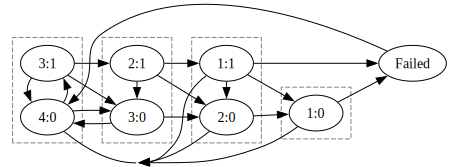

In [10]:
cmm = get_dr_cmm(4, conservative_failure_params)
get_graphviz(cmm, node_to_group=working_and_backup_grouping(cmm))

In [ ]:
# Also try to vary automatic recovery rate + other parameters 5 outputs
# Try to get the 5d symbolic mttf
# Try to generate graphs automatically +++ Good graph visualization
# Try to get parameter sweep sliders for graphs
failure_rates = generate_fractions(Fraction(1, 1000 * 24), Fraction(1, 50 * 24), 1000)
x_axis = [float(x) * 24 * 365.25 for x in failure_rates]
mttf_three_node = []
mttf_five_node = []
mttf_opt_three_node = []
mttf_opt_1b_three_node = []

for failure_rps in failure_rates:
    params = FailureParameters(
        failure_rps=failure_rps,
        recovery_rps=Fraction(1, 5),
        human_recovery_rps=Fraction(1, 5),
        update_rps=Fraction((60 * 60 * 1000), 10),
        outdate_rps=Fraction((60 * 60 * 1000), 10),
    )
    cmm3 = get_three_node_CMM(params)
    cmm5 = get_five_node_CMM(params)
    cmm3opt = get_optimistic_three_node_CMM(params)
    cmm3opt1b = get_optimistic_naiive_backup_three_node_CMM(params)

    cmm3_ans = wolfram_session.evaluate(
        wl.Mean(
            wl.FirstPassageTimeDistribution(
                get_wolfram_markov_model(cmm3), get_state_to_id_dict(cmm3)["Failed"] + 1
            )
        )
    )
    cmm5_ans = wolfram_session.evaluate(
        wl.Mean(
            wl.FirstPassageTimeDistribution(
                get_wolfram_markov_model(cmm5), get_state_to_id_dict(cmm5)["Failed"] + 1
            )
        )
    )
    cmm3opt_ans = wolfram_session.evaluate(
        wl.Mean(
            wl.FirstPassageTimeDistribution(
                get_wolfram_markov_model(cmm3opt),
                get_state_to_id_dict(cmm3opt)["Failed"] + 1,
            )
        )
    )
    cmm3opt_1b_ans = wolfram_session.evaluate(
        wl.Mean(
            wl.FirstPassageTimeDistribution(
                get_wolfram_markov_model(cmm3opt1b),
                get_state_to_id_dict(cmm3opt1b)["Failed"] + 1,
            )
        )
    )

    mttf_three_node.append(convert_wolfram_number(cmm3_ans) / 24 / 365.25)
    mttf_five_node.append(convert_wolfram_number(cmm5_ans) / 24 / 365.25)
    mttf_opt_three_node.append(convert_wolfram_number(cmm3opt_ans) / 24 / 365.25)
    mttf_opt_1b_three_node.append(convert_wolfram_number(cmm3opt_1b_ans) / 24 / 365.25)

In [ ]:
# Also try to vary automatic recovery rate + other parameters 5 outputs
# Try to get the 5d symbolic mttf
# Try to generate graphs automatically +++ Good graph visualization
# Try to get parameter sweep sliders for graphs
failure_rates = generate_fractions(Fraction(1, 1000 * 24), Fraction(1, 50 * 24), 20)
x_axis = [float(x) * 24 * 365.25 for x in failure_rates]

mttf_three_node = []
mttf_four_node = []
mttf_five_node = []
mttf_six_node = []
mttf_seven_node = []

mttf_opt_four_node = []
mttf_opt_five_node = []
mttf_opt_six_node = []
mttf_opt_seven_node = []

mttf_three_one_backup = []
mttf_three_two_backup = []
mttf_three_three_backup = []

mttf_four_one_backup = []
mttf_four_two_backup = []
mttf_four_three_backup = []

mttf_five_one_backup = []
mttf_five_two_backup = []
mttf_five_three_backup = []

mttf_six_one_backup = []
mttf_six_two_backup = []
mttf_six_three_backup = []

backup_arrs = [
    mttf_three_one_backup,
    mttf_three_two_backup,
    mttf_three_three_backup,
    mttf_four_one_backup,
    mttf_four_two_backup,
    mttf_four_three_backup,
    mttf_five_one_backup,
    mttf_five_two_backup,
    mttf_five_three_backup,
    mttf_six_one_backup,
    mttf_six_two_backup,
    mttf_six_three_backup,
]


with WolframLanguageSession(my_wolfram_kernel_path) as wolfram_session:
    for failure_rps in failure_rates:
        params = FailureParameters(
            failure_rps=failure_rps,
            recovery_rps=Fraction(1, 5),
            human_recovery_rps=Fraction(1, 5),
            update_rps=Fraction((60 * 60 * 1000), 10),
            outdate_rps=Fraction((60 * 60 * 1000), 10),
        )
        cmm3 = get_cmm(3, params)
        cmm5 = get_cmm(5, params)
        cmm4 = get_cmm(4, params)
        cmm6 = get_cmm(6, params)
        cmm7 = get_cmm(7, params)

        cmm4opt = get_dr_cmm(4, params)
        cmm5opt = get_dr_cmm(5, params)
        cmm6opt = get_dr_cmm(6, params)
        cmm7opt = get_dr_cmm(7, params)

        cmm3_1b = get_dr_backup_cmm(3, 1, params, params)

        cmm3_ans = wolfram_session.evaluate(
            wl.Mean(
                wl.FirstPassageTimeDistribution(
                    get_wolfram_markov_model(cmm3),
                    get_state_to_id_dict(cmm3)["Failed"] + 1,
                )
            )
        )
        cmm5_ans = wolfram_session.evaluate(
            wl.Mean(
                wl.FirstPassageTimeDistribution(
                    get_wolfram_markov_model(cmm5),
                    get_state_to_id_dict(cmm5)["Failed"] + 1,
                )
            )
        )
        cmm4_ans = wolfram_session.evaluate(
            wl.Mean(
                wl.FirstPassageTimeDistribution(
                    get_wolfram_markov_model(cmm4),
                    get_state_to_id_dict(cmm4)["Failed"] + 1,
                )
            )
        )
        cmm6_ans = wolfram_session.evaluate(
            wl.Mean(
                wl.FirstPassageTimeDistribution(
                    get_wolfram_markov_model(cmm6),
                    get_state_to_id_dict(cmm6)["Failed"] + 1,
                )
            )
        )
        cmm7_ans = wolfram_session.evaluate(
            wl.Mean(
                wl.FirstPassageTimeDistribution(
                    get_wolfram_markov_model(cmm7),
                    get_state_to_id_dict(cmm7)["Failed"] + 1,
                )
            )
        )

        cmm4opt_ans = wolfram_session.evaluate(
            wl.Mean(
                wl.FirstPassageTimeDistribution(
                    get_wolfram_markov_model(cmm4opt),
                    get_state_to_id_dict(cmm4opt)["Failed"] + 1,
                )
            )
        )
        cmm5opt_ans = wolfram_session.evaluate(
            wl.Mean(
                wl.FirstPassageTimeDistribution(
                    get_wolfram_markov_model(cmm5opt),
                    get_state_to_id_dict(cmm5opt)["Failed"] + 1,
                )
            )
        )
        cmm6opt_ans = wolfram_session.evaluate(
            wl.Mean(
                wl.FirstPassageTimeDistribution(
                    get_wolfram_markov_model(cmm6opt),
                    get_state_to_id_dict(cmm6opt)["Failed"] + 1,
                )
            )
        )
        cmm7opt_ans = wolfram_session.evaluate(
            wl.Mean(
                wl.FirstPassageTimeDistribution(
                    get_wolfram_markov_model(cmm7opt),
                    get_state_to_id_dict(cmm7opt)["Failed"] + 1,
                )
            )
        )

        for num_reps in range(3, 7):
            for num_backups in range(1, 4):
                cmm = get_dr_backup_cmm(num_reps, num_backups, params, params)
                cmm_ans = wolfram_session.evaluate(
                    wl.Mean(
                        wl.FirstPassageTimeDistribution(
                            get_wolfram_markov_model(cmm),
                            get_state_to_id_dict(cmm)["Failed"] + 1,
                        )
                    )
                )
                backup_arrs[(num_reps - 3) * 3 + num_backups - 1].append(
                    convert_wolfram_number(cmm_ans) / 24 / 365.25
                )

        cmm3_1b_ans = wolfram_session.evaluate(
            wl.Mean(
                wl.FirstPassageTimeDistribution(
                    get_wolfram_markov_model(cmm3_1b),
                    get_state_to_id_dict(cmm3_1b)["Failed"] + 1,
                )
            )
        )

        mttf_three_node.append(convert_wolfram_number(cmm3_ans) / 24 / 365.25)
        mttf_five_node.append(convert_wolfram_number(cmm5_ans) / 24 / 365.25)
        mttf_four_node.append(convert_wolfram_number(cmm4_ans) / 24 / 365.25)
        mttf_six_node.append(convert_wolfram_number(cmm6_ans) / 24 / 365.25)
        mttf_seven_node.append(convert_wolfram_number(cmm7_ans) / 24 / 365.25)

        mttf_opt_four_node.append(convert_wolfram_number(cmm4opt_ans) / 24 / 365.25)
        mttf_opt_five_node.append(convert_wolfram_number(cmm5opt_ans) / 24 / 365.25)
        mttf_opt_six_node.append(convert_wolfram_number(cmm6opt_ans) / 24 / 365.25)
        mttf_opt_seven_node.append(convert_wolfram_number(cmm7opt_ans) / 24 / 365.25)
        mttf_three_one_backup.append(convert_wolfram_number(cmm3_1b_ans) / 24 / 365.25)

In [ ]:
y_axis_value_names = [
    (mttf_three_node, "mttf_three_node"),
    (mttf_four_node, "mttf_four_node"),
    (mttf_five_node, "mttf_five_node"),
    (mttf_six_node, "mttf_six_node"),
    (mttf_seven_node, "mttf_seven_node"),
    (mttf_opt_three_node, "mttf_opt_three_node"),
    (mttf_opt_four_node, "mttf_opt_four_node"),
    (mttf_opt_five_node, "mttf_opt_five_node"),
    (mttf_opt_six_node, "mttf_opt_six_node"),
    (mttf_opt_seven_node, "mttf_opt_seven_node"),
    (mttf_opt_1b_three_node, "mttf_opt_1b_three_node"),
    (mttf_three_one_backup, "mttf_three_one_backup"),
    (mttf_three_two_backup, "mttf_three_two_backup"),
    (mttf_three_three_backup, "mttf_three_three_backup"),
    (mttf_four_one_backup, "mttf_four_one_backup"),
    (mttf_four_two_backup, "mttf_four_two_backup"),
    (mttf_four_three_backup, "mttf_four_three_backup"),
    (mttf_five_one_backup, "mttf_five_one_backup"),
    (mttf_five_two_backup, "mttf_five_two_backup"),
    (mttf_five_three_backup, "mttf_five_three_backup"),
    (mttf_six_one_backup, "mttf_six_one_backup"),
    (mttf_six_two_backup, "mttf_six_two_backup"),
    (mttf_six_three_backup, "mttf_six_three_backup"),
]

mttf_vs_failure_rate = Graph(
    title="mttf vs failure rate/year",
    x_axis_name="failure rate/yr",
    y_axis_name="mttf (years)",
    lines=[
        Line(x_values=x_axis, y_values=val_name[0], name=val_name[1])
        for val_name in y_axis_value_names
    ],
)

make_fig(mttf_vs_failure_rate)

In [ ]:
# Also try to vary automatic recovery rate + other parameters 5 outputs
# Try to get the 5d symbolic mttf
# Try to generate graphs automatically +++ Good graph visualization
# Try to get parameter sweep sliders for graphs
failure_rates = generate_fractions(Fraction(1, 5), Fraction(1, 5 * 24 * 10), 40)
x_axis = [float(x) * 24 * 365.25 for x in failure_rates]

mttf_three_node = []
mttf_four_node = []
mttf_five_node = []
mttf_six_node = []
mttf_seven_node = []

mttf_opt_four_node = []
mttf_opt_five_node = []
mttf_opt_six_node = []
mttf_opt_seven_node = []

mttf_three_one_backup = []
mttf_three_two_backup = []
mttf_three_three_backup = []

mttf_four_one_backup = []
mttf_four_two_backup = []
mttf_four_three_backup = []

mttf_five_one_backup = []
mttf_five_two_backup = []
mttf_five_three_backup = []

mttf_six_one_backup = []
mttf_six_two_backup = []
mttf_six_three_backup = []

backup_arrs = [
    mttf_three_one_backup,
    mttf_three_two_backup,
    mttf_three_three_backup,
    mttf_four_one_backup,
    mttf_four_two_backup,
    mttf_four_three_backup,
    mttf_five_one_backup,
    mttf_five_two_backup,
    mttf_five_three_backup,
    mttf_six_one_backup,
    mttf_six_two_backup,
    mttf_six_three_backup,
]


with WolframLanguageSession(my_wolfram_kernel_path) as wolfram_session:
    for failure_rps in failure_rates:
        params = FailureParameters(
            failure_rps=Fraction(1, 50 * 24),
            recovery_rps=Fraction(1, 5),
            human_recovery_rps=failure_rps,
            update_rps=Fraction((60 * 60 * 1000), 10),
            outdate_rps=Fraction((60 * 60 * 1000), 10),
        )
        cmm3 = get_cmm(3, params)
        cmm5 = get_cmm(5, params)
        cmm4 = get_cmm(4, params)
        cmm6 = get_cmm(6, params)
        cmm7 = get_cmm(7, params)

        cmm4opt = get_dr_cmm(4, params)
        cmm5opt = get_dr_cmm(5, params)
        cmm6opt = get_dr_cmm(6, params)
        cmm7opt = get_dr_cmm(7, params)

        cmm3_1b = get_dr_backup_cmm(3, 1, params, params)

        cmm3_ans = wolfram_session.evaluate(
            wl.Mean(
                wl.FirstPassageTimeDistribution(
                    get_wolfram_markov_model(cmm3),
                    get_state_to_id_dict(cmm3)["Failed"] + 1,
                )
            )
        )
        cmm5_ans = wolfram_session.evaluate(
            wl.Mean(
                wl.FirstPassageTimeDistribution(
                    get_wolfram_markov_model(cmm5),
                    get_state_to_id_dict(cmm5)["Failed"] + 1,
                )
            )
        )
        cmm4_ans = wolfram_session.evaluate(
            wl.Mean(
                wl.FirstPassageTimeDistribution(
                    get_wolfram_markov_model(cmm4),
                    get_state_to_id_dict(cmm4)["Failed"] + 1,
                )
            )
        )
        cmm6_ans = wolfram_session.evaluate(
            wl.Mean(
                wl.FirstPassageTimeDistribution(
                    get_wolfram_markov_model(cmm6),
                    get_state_to_id_dict(cmm6)["Failed"] + 1,
                )
            )
        )
        cmm7_ans = wolfram_session.evaluate(
            wl.Mean(
                wl.FirstPassageTimeDistribution(
                    get_wolfram_markov_model(cmm7),
                    get_state_to_id_dict(cmm7)["Failed"] + 1,
                )
            )
        )

        cmm4opt_ans = wolfram_session.evaluate(
            wl.Mean(
                wl.FirstPassageTimeDistribution(
                    get_wolfram_markov_model(cmm4opt),
                    get_state_to_id_dict(cmm4opt)["Failed"] + 1,
                )
            )
        )
        cmm5opt_ans = wolfram_session.evaluate(
            wl.Mean(
                wl.FirstPassageTimeDistribution(
                    get_wolfram_markov_model(cmm5opt),
                    get_state_to_id_dict(cmm5opt)["Failed"] + 1,
                )
            )
        )
        cmm6opt_ans = wolfram_session.evaluate(
            wl.Mean(
                wl.FirstPassageTimeDistribution(
                    get_wolfram_markov_model(cmm6opt),
                    get_state_to_id_dict(cmm6opt)["Failed"] + 1,
                )
            )
        )
        cmm7opt_ans = wolfram_session.evaluate(
            wl.Mean(
                wl.FirstPassageTimeDistribution(
                    get_wolfram_markov_model(cmm7opt),
                    get_state_to_id_dict(cmm7opt)["Failed"] + 1,
                )
            )
        )

        for num_reps in range(3, 7):
            for num_backups in range(1, 4):
                cmm = get_dr_backup_cmm(num_reps, num_backups, params, params)
                cmm_ans = wolfram_session.evaluate(
                    wl.Mean(
                        wl.FirstPassageTimeDistribution(
                            get_wolfram_markov_model(cmm),
                            get_state_to_id_dict(cmm)["Failed"] + 1,
                        )
                    )
                )
                backup_arrs[(num_reps - 3) * 3 + num_backups - 1].append(
                    convert_wolfram_number(cmm_ans) / 24 / 365.25
                )

        cmm3_1b_ans = wolfram_session.evaluate(
            wl.Mean(
                wl.FirstPassageTimeDistribution(
                    get_wolfram_markov_model(cmm3_1b),
                    get_state_to_id_dict(cmm3_1b)["Failed"] + 1,
                )
            )
        )

        mttf_three_node.append(convert_wolfram_number(cmm3_ans) / 24 / 365.25)
        mttf_five_node.append(convert_wolfram_number(cmm5_ans) / 24 / 365.25)
        mttf_four_node.append(convert_wolfram_number(cmm4_ans) / 24 / 365.25)
        mttf_six_node.append(convert_wolfram_number(cmm6_ans) / 24 / 365.25)
        mttf_seven_node.append(convert_wolfram_number(cmm7_ans) / 24 / 365.25)

        mttf_opt_four_node.append(convert_wolfram_number(cmm4opt_ans) / 24 / 365.25)
        mttf_opt_five_node.append(convert_wolfram_number(cmm5opt_ans) / 24 / 365.25)
        mttf_opt_six_node.append(convert_wolfram_number(cmm6opt_ans) / 24 / 365.25)
        mttf_opt_seven_node.append(convert_wolfram_number(cmm7opt_ans) / 24 / 365.25)
        mttf_three_one_backup.append(convert_wolfram_number(cmm3_1b_ans) / 24 / 365.25)

In [ ]:
y_axis_value_names = [
    (mttf_three_node, "mttf_three_node"),
    (mttf_four_node, "mttf_four_node"),
    (mttf_five_node, "mttf_five_node"),
    (mttf_six_node, "mttf_six_node"),
    (mttf_seven_node, "mttf_seven_node"),
    (mttf_opt_three_node, "mttf_opt_three_node"),
    (mttf_opt_four_node, "mttf_opt_four_node"),
    (mttf_opt_five_node, "mttf_opt_five_node"),
    (mttf_opt_six_node, "mttf_opt_six_node"),
    (mttf_opt_seven_node, "mttf_opt_seven_node"),
    (mttf_opt_1b_three_node, "mttf_opt_1b_three_node"),
    (mttf_three_one_backup, "mttf_three_one_backup"),
    (mttf_three_two_backup, "mttf_three_two_backup"),
    (mttf_three_three_backup, "mttf_three_three_backup"),
    (mttf_four_one_backup, "mttf_four_one_backup"),
    (mttf_four_two_backup, "mttf_four_two_backup"),
    (mttf_four_three_backup, "mttf_four_three_backup"),
    (mttf_five_one_backup, "mttf_five_one_backup"),
    (mttf_five_two_backup, "mttf_five_two_backup"),
    (mttf_five_three_backup, "mttf_five_three_backup"),
    (mttf_six_one_backup, "mttf_six_one_backup"),
    (mttf_six_two_backup, "mttf_six_two_backup"),
    (mttf_six_three_backup, "mttf_six_three_backup"),
]

mttf_vs_failure_rate = Graph(
    title="mttf vs failure rate/year",
    x_axis_name="human recovery rate/yr",
    y_axis_name="mttf (years)",
    lines=[
        Line(x_values=x_axis, y_values=val_name[0], name=val_name[1])
        for val_name in y_axis_value_names
    ],
)

make_fig(mttf_vs_failure_rate)